# Project 3 Codebook

## Topic: Spatial Analysis of Exposure to Respiratory Hazards and School Performance in Riverside, California.

#### Data and Time Frame for Analysis
1. [EJScreen data - 2020](https://open.quiltdata.com/b/spatial-ucr/tree/epa/ejscreen/)
2. [NCES/Districts - 2018/2019](https://open.quiltdata.com/b/spatial-ucr/tree/nces/schools/)
3. [ACS- 2018](https://open.quiltdata.com/b/spatial-ucr/tree/census/acs/)
4. [SEDA- Standardized test scores administered in 3rd through 8 th grade in mathematics and Reading Language Arts (RLA) over the 2008-09 through 2017-18 school years](https://edopportunity.org/)

#### TASKS
- Import software
- Retrieve Data from all four data sources.
- Create GeoDataframes for EPA EJScreen and SEDA using ACS and NCES geometry.
- Subset data for Riverside specific EJScreen respiratory hazards index and schooling outcomes for the Riverside Unified School District using SEDA. 
- Overlay RUSD schooling outcomes and EJ Respiratory Hazards Index.


### 1: Download software 

In [1]:
# Import software

import pandas as pd
import geopandas as gpd 
import matplotlib.pyplot as plt 
import contextily as ctx
import numpy as np
import quilt3
from geopandas_view import view 
import libpysal as lps
import seaborn as sns
import tobler as tob
plt.rcParams['figure.figsize'] = [20, 10]


###  2: Retrieve and Adjust Data

#### 2.1 Environmental Justice Screen Data From EPA

In [2]:
# Retrieve EPA EJ Screen data from UCR CGS Quilt Bucket

b = quilt3.Bucket("s3://spatial-ucr")
b.fetch("epa/ejscreen/ejscreen_2020.parquet", "./ejscreen_2020.parquet"), # Might be a good idea to get 2018
ej = pd.read_parquet('ejscreen_2020.parquet')
ej.head()

100%|██████████| 146M/146M [00:06<00:00, 21.0MB/s] 


,OBJECTID,ID,ACSTOTPOP,ACSIPOVBAS,ACSEDUCBAS,ACSTOTHH,ACSTOTHU,MINORPOP,MINORPCT,LOWINCOME,...,T_OZONE,T_OZONE_D2,T_PM25,T_PM25_D2,AREALAND,AREAWATER,NPL_CNT,TSDF_CNT,Shape_Length,Shape_Area
0,1,010010201001,636,636,418,294,294,104,0.163522,245,...,36.8 ppb (15%ile),54%ile,9.69 ug/m3 (86%ile),52%ile,4259428.0,28435.0,0,0,13443.155206,6.040790e+06
1,2,010010201002,1287,1287,885,471,485,278,0.216006,210,...,36.8 ppb (15%ile),36%ile,9.69 ug/m3 (86%ile),28%ile,5558385.0,0.0,0,0,11917.089598,7.834160e+06
2,3,010010202001,810,802,568,322,370,548,0.676543,402,...,36.8 ppb (16%ile),70%ile,9.71 ug/m3 (86%ile),72%ile,2058380.0,0.0,0,0,7770.915121,2.900774e+06
3,4,010010202002,1218,1016,875,397,482,670,0.550082,400,...,36.8 ppb (16%ile),67%ile,9.71 ug/m3 (86%ile),69%ile,1267299.0,5669.0,0,0,6506.804784,1.793332e+06
4,5,010010203001,2641,2641,1849,948,1049,899,0.340401,814,...,36.9 ppb (16%ile),51%ile,9.75 ug/m3 (86%ile),48%ile,3866515.0,9054.0,0,0,11070.367848,5.461602e+06


In [3]:
# Rename EJ column to state GEOID
ej.rename(columns = {'ID' : 'GEOID'}, inplace = True)
# ej.head()

In [4]:
ej.columns

Index(['OBJECTID', 'GEOID', 'ACSTOTPOP', 'ACSIPOVBAS', 'ACSEDUCBAS',
       'ACSTOTHH', 'ACSTOTHU', 'MINORPOP', 'MINORPCT', 'LOWINCOME',
       ...
       'T_OZONE', 'T_OZONE_D2', 'T_PM25', 'T_PM25_D2', 'AREALAND', 'AREAWATER',
       'NPL_CNT', 'TSDF_CNT', 'Shape_Length', 'Shape_Area'],
      dtype='object', length=141)

In [5]:
type(ej)

pandas.core.frame.DataFrame

Note: EPA EJ Screen is not a geodataframe so we need ACS census blockgroup data to convert it into geodataframe.

In [6]:
# Download USA Census block groups from the 2018 ACS via Quilt
geoms = gpd.read_parquet('s3://spatial-ucr/census/acs/acs_2018_bg.parquet')
geoms.head()

,n_persons_under_18,n_persons_over_60,n_persons_over_75,n_persons_over_15,n_married,n_widowed_divorced,n_total_families,n_female_headed_families,n_nonhisp_white_persons,n_nonhisp_black_persons,...,p_female_headed_families,p_nonhisp_white_persons,p_nonhisp_black_persons,p_hispanic_persons,p_native_persons,p_asian_persons,p_hawaiian_persons,p_asian_indian_persons,p_veterans,geometry
GEOID,,,,,,,,,,,,,,,,,,,,,
020130001003,287.0,213.0,26.0,1164.0,154.0,218.0,280.0,29.0,234.0,4.0,...,10.357143,16.846652,0.287977,6.839453,41.324694,23.182145,1.007919,23.182145,4.463643,"MULTIPOLYGON (((-159.91033 54.81417, -159.9057..."
020160001001,175.0,157.0,25.0,807.0,64.0,146.0,127.0,10.0,203.0,41.0,...,7.874016,20.949432,4.231166,11.764706,48.710010,9.907121,3.405573,9.907121,12.074303,"MULTIPOLYGON (((179.38874 51.94192, 179.40456 ..."
020160002001,320.0,224.0,21.0,1884.0,256.0,302.0,248.0,3.0,270.0,91.0,...,1.209677,12.517385,4.218822,12.888271,1.205378,66.759388,0.834492,66.759388,2.781641,"MULTIPOLYGON (((-167.24289 53.85467, -167.2370..."
020160002002,468.0,335.0,29.0,2220.0,304.0,435.0,341.0,6.0,916.0,114.0,...,1.759531,34.908537,4.344512,15.472561,5.182927,33.574695,3.696646,33.574695,3.620427,"MULTIPOLYGON (((-167.90386 53.22286, -167.8910..."
020200001011,75.0,79.0,37.0,404.0,49.0,73.0,63.0,0.0,351.0,4.0,...,0.000000,75.646552,0.862069,0.000000,12.715517,3.232759,0.000000,3.232759,9.482759,"MULTIPOLYGON (((-149.47075 61.45923, -149.4505..."


In [7]:
# Merge EJ and ACS data
ej_new = geoms.merge(ej, on='GEOID')
ej_new.head()

,GEOID,n_persons_under_18,n_persons_over_60,n_persons_over_75,n_persons_over_15,n_married,n_widowed_divorced,n_total_families,n_female_headed_families,n_nonhisp_white_persons,...,T_OZONE,T_OZONE_D2,T_PM25,T_PM25_D2,AREALAND,AREAWATER,NPL_CNT,TSDF_CNT,Shape_Length,Shape_Area
0,020130001003,287.0,213.0,26.0,1164.0,154.0,218.0,280.0,29.0,234.0,...,None,None,None,None,1.178921e+09,4.114837e+09,0,0,1.026354e+06,1.615713e+10
1,020160001001,175.0,157.0,25.0,807.0,64.0,146.0,127.0,10.0,203.0,...,None,None,None,None,8.552028e+09,2.208385e+10,1,2,4.442060e+06,6.008803e+10
2,020160002001,320.0,224.0,21.0,1884.0,256.0,302.0,248.0,3.0,270.0,...,None,None,None,None,7.752357e+08,6.422767e+08,0,0,2.614006e+05,4.075118e+09
3,020160002002,468.0,335.0,29.0,2220.0,304.0,435.0,341.0,6.0,916.0,...,None,None,None,None,2.048247e+09,2.459880e+09,0,1,6.481758e+05,1.276803e+10
4,020200001011,75.0,79.0,37.0,404.0,49.0,73.0,63.0,0.0,351.0,...,None,None,None,None,5.402439e+07,1.640616e+07,0,0,1.053080e+05,3.072696e+08


In [8]:
#Command to converting ej_new to geodataframe
ej_new= gpd.GeoDataFrame(ej_new)
type(ej_new)

geopandas.geodataframe.GeoDataFrame

In [9]:
# Filter EJ Screen data so it only displays CA 
ca_ej = ej_new[ej_new.GEOID.str.startswith('06')]
ca_ej.head()

,GEOID,n_persons_under_18,n_persons_over_60,n_persons_over_75,n_persons_over_15,n_married,n_widowed_divorced,n_total_families,n_female_headed_families,n_nonhisp_white_persons,...,T_OZONE,T_OZONE_D2,T_PM25,T_PM25_D2,AREALAND,AREAWATER,NPL_CNT,TSDF_CNT,Shape_Length,Shape_Area
10297,060190045062,153.0,778.0,334.0,1567.0,313.0,447.0,389.0,0.0,1293.0,...,63 ppb (98%ile),19%ile,13.9 ug/m3 (99%ile),15%ile,1285301.0,0.0,0,1,6016.799236,2.009254e+06
10298,060190046011,365.0,630.0,233.0,1475.0,253.0,472.0,437.0,17.0,881.0,...,62.7 ppb (98%ile),64%ile,14 ug/m3 (99%ile),65%ile,1176829.0,0.0,0,1,8153.747224,1.839061e+06
10299,060190046012,377.0,428.0,141.0,1139.0,246.0,255.0,294.0,0.0,914.0,...,62.7 ppb (98%ile),41%ile,14 ug/m3 (99%ile),38%ile,639720.0,0.0,0,0,4000.409939,9.997658e+05
10300,060190046021,75.0,298.0,77.0,591.0,196.0,105.0,208.0,0.0,508.0,...,63 ppb (98%ile),32%ile,14.1 ug/m3 (99%ile),28%ile,808740.0,0.0,0,0,4523.951503,1.263881e+06
10301,060190046022,282.0,156.0,42.0,859.0,272.0,112.0,276.0,0.0,610.0,...,63 ppb (98%ile),43%ile,14.1 ug/m3 (99%ile),40%ile,1126026.0,0.0,0,0,6011.567284,1.759425e+06


In [10]:
# Filter out EJ Index for Air toxics respiratory hazard index
D_RESP_2 = ca_ej.D_RESP_2 
ca_ej.D_RESP_2 = D_RESP_2.replace(to_replace= "None", value=np.nan).astype(float)

/opt/tljh/user/lib/python3.7/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [11]:
# Create variable for Riverside LA County using the fips code

riv_ej = ca_ej[ca_ej.GEOID.str.startswith("06065")] # Riverside County EJSCREEN

In [12]:
# Checking Data for Orange County
#riv_ej.head()
riv_ej.shape

(1030, 177)

In [13]:
# New dataframe for respiratory hazards index, minority percent, low income percent 
new_riverside = riv_ej[['D_RESP_2','MINORPCT','VULEOPCT','LOWINCPCT', 'P_RESP_D2','geometry']]
new_riverside.head()

,D_RESP_2,MINORPCT,VULEOPCT,LOWINCPCT,P_RESP_D2,geometry
22892,268.925031,0.888638,0.677501,0.466364,86.972203746,"MULTIPOLYGON (((-117.35750 33.99337, -117.3574..."
22893,96.574481,0.649800,0.561252,0.472703,72.8073777371,"MULTIPOLYGON (((-117.36868 33.98814, -117.3684..."
22894,248.739003,0.729181,0.625356,0.521531,85.8057092585,"MULTIPOLYGON (((-117.37502 34.00081, -117.3748..."
22895,446.902269,0.841341,0.616015,0.390689,93.8602866595,"MULTIPOLYGON (((-117.38028 34.00716, -117.3778..."
22896,146.929484,0.894737,0.637087,0.379437,78.1073043776,"MULTIPOLYGON (((-117.37605 34.00218, -117.3760..."


In [14]:
#new_riverside.groupby(by ='MINORPCT').sum()

Note: 
- MINORPCT is the % people of color
- P_RESP_D2 is the Percentile for EJ Index for Air toxics respiratory hazard index
- D_RESP_2 is the EJ Index for Air toxics respiratory hazard index
- LOWINCPCT is the % low-income
- VULEOPCT is the "Demographic Index (based on 2 factors, % low-income and % people of color)"

In [15]:
#Statistics
new_riverside.describe()

,D_RESP_2,MINORPCT,VULEOPCT,LOWINCPCT
count,1030.000000,1030.000000,1030.000000,1030.000000
mean,161.217384,0.612259,0.486489,0.360719
std,239.451824,0.237403,0.190007,0.197605
min,-397.647715,0.000000,0.000000,0.000000
25%,-10.833675,0.449066,0.338977,0.202769
50%,113.540281,0.630449,0.473643,0.333192
75%,296.013932,0.807316,0.636008,0.506338
max,1909.488471,1.000000,0.964012,1.000000


### 3: Merge District Data w/ EJ Data

In [16]:
# Upload school districts data

districts = gpd.read_parquet('s3://spatial-ucr/nces/districts/school_districts_1819.parquet')

In [17]:
# Subset of the california schools from the US data
CA_dist = districts[districts.STATEFP == "06"]
CA_dist.head()

,STATEFP,ELSDLEA,SCSDLEA,UNSDLEA,GEOID,NAME,LSAD,LOGRADE,HIGRADE,MTFCC,SDTYP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,GEO_YEAR,SCHOOLYEAR,geometry
100,06,None,29130,None,0629130,Oroville Union High School District,00,09,12,G5410,None,E,1.661957e+09,69687872.0,+39.6041742,-121.4309121,2019,2018-2019,"POLYGON ((-121.41109 39.92943, -121.41100 39.9..."
101,06,None,06005,None,0606005,Scott Valley Unified School District (9-12),00,09,12,G5410,A,F,1.665939e+09,4125720.0,+41.2663944,-123.1705167,2019,2018-2019,"POLYGON ((-122.94536 41.18142, -122.94603 41.1..."
102,06,None,02630,None,0602630,Anaheim Union High School District,00,07,12,G5410,None,E,1.054074e+08,442229.0,+33.8268024,-117.9645681,2019,2018-2019,"POLYGON ((-117.90866 33.86321, -117.90720 33.8..."
103,06,None,18060,None,0618060,Huntington Beach Union High School District,00,09,12,G5410,None,E,1.156663e+08,103525862.0,+33.6845747,-118.0212994,2019,2018-2019,"MULTIPOLYGON (((-118.06832 33.71677, -118.0685..."
104,06,None,30250,None,0630250,Petaluma Joint Union High School District,00,07,12,G5410,None,E,6.364750e+08,43379841.0,+38.1988275,-122.6342934,2019,2018-2019,"POLYGON ((-122.58311 38.35780, -122.58265 38.3..."


In [18]:
# Locate Riverside Unified School District (RUSD)- better to make sure its in California

rusd_CA = districts[districts['STATEFP'].str.lower().str.contains('06')]
rusd = rusd_CA[rusd_CA['NAME'].str.lower().str.contains('riverside unified')]
rusd.head()


,STATEFP,ELSDLEA,SCSDLEA,UNSDLEA,GEOID,NAME,LSAD,LOGRADE,HIGRADE,MTFCC,SDTYP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,GEO_YEAR,SCHOOLYEAR,geometry
1598,06,None,None,33150,0633150,Riverside Unified School District,00,KG,12,G5420,None,E,231195333.0,6617991.0,+33.9233125,-117.3778383,2019,2018-2019,"POLYGON ((-117.27942 34.00459, -117.27923 33.9..."


In [19]:
# Now, let's overlay the EPA EJ data (that was combined with ACS data) on top of the RUSD shape

rusd_ej = gpd.overlay(riv_ej,rusd, how='intersection')


### 4: Combine School Locations with School District/EJ Map

In [20]:
# Download NCES school location data 
schools = gpd.read_parquet("s3://spatial-ucr/nces/schools/schools_1819.parquet")
#schools.head()

In [21]:
# Download SEDA learning outcomes data
seda = pd.read_csv("https://stacks.stanford.edu/file/druid:db586ns4974/seda_school_pool_gcs_4.0.csv",converters={"sedasch":str})
seda.sedasch=seda.sedasch.str.rjust(12, "0")
#seda.head()

In [22]:
# Convert NCES data into a GeoDataFrame
school_geoms = schools[['NCESSCH','CNTY','NMCNTY', 'geometry']]
school_geoms.head()

,NCESSCH,CNTY,NMCNTY,geometry
0,010000500870,01095,Marshall County,POINT (-86.20617 34.26019)
1,010000500871,01095,Marshall County,POINT (-86.20488 34.26223)
2,010000500879,01095,Marshall County,POINT (-86.22014 34.27332)
3,010000500889,01095,Marshall County,POINT (-86.22181 34.25270)
4,010000501616,01095,Marshall County,POINT (-86.19329 34.28985)


In [23]:
# Merge SEDA and NCES data
seda_merge = seda.merge(school_geoms, left_on="sedasch", right_on= "NCESSCH")
#seda_merge.head()

In [24]:
# Convert merged NCES/SEDA data into a GeoDataFrame and plot it
seda_merge= gpd.GeoDataFrame(seda_merge)
#seda_merge.plot()

In [25]:
# Subset data to only locate schools in Riverside County 
riv_schools = seda_merge[seda_merge['CNTY']=='06065']
#riv_schools.plot()

In [26]:
# Subset school data to find schools in RUSD

rusd_schools = gpd.overlay(riv_schools, rusd, how='intersection')

### 5: Voronoi Polygons

In [27]:
# Subset of rusd schools with only mean scores
rusd_pts= rusd_schools[['gcs_mn_avg_ol','geometry']]
rusd_pts.head()

,gcs_mn_avg_ol,geometry
0,8.098470,POINT (-117.30967 33.88970)
1,4.939048,POINT (-117.30644 33.88844)
2,3.253884,POINT (-117.43514 33.94446)
3,3.960433,POINT (-117.36408 33.95469)
4,3.599937,POINT (-117.37885 33.98955)


<AxesSubplot:>

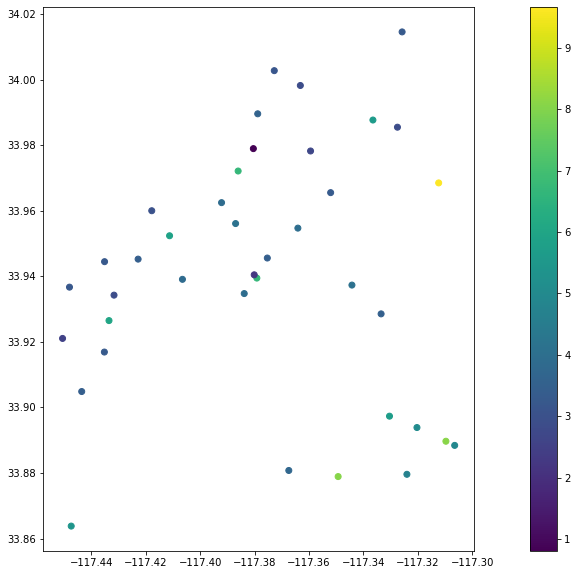

In [28]:
rusd_pts.plot(column='gcs_mn_avg_ol', legend=True)

<AxesSubplot:>

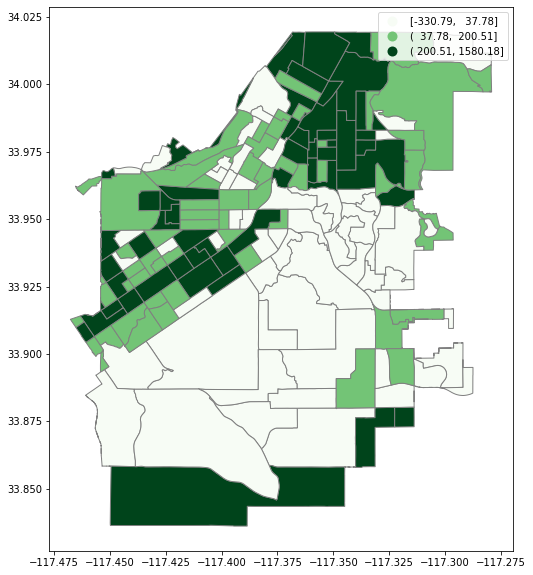

In [87]:
# Subset for EJ screen for RUSD only containing Respiratory index and geometry

EJ_RUSD= rusd_ej[['D_RESP_2','geometry']]
EJ_RUSD.plot(column='D_RESP_2', cmap='Greens', scheme='Quantiles', k=3,edgecolor='grey',
        legend=True)

EJ with RUSD and White Demographic 

<AxesSubplot:>

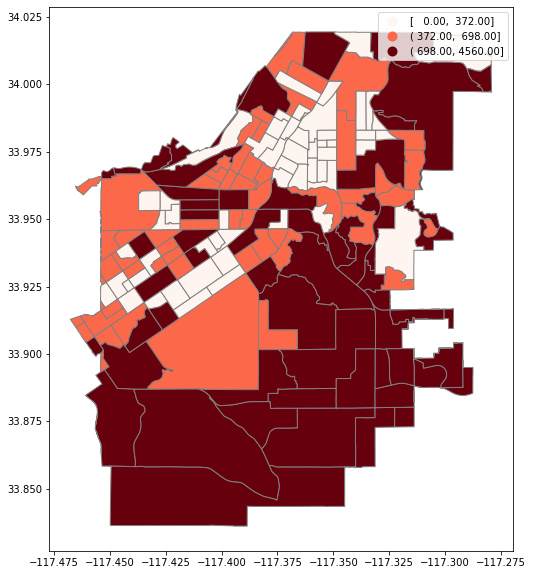

In [90]:
EJ_RUSD_white_demographic= rusd_ej[['n_nonhisp_white_persons','geometry']]
EJ_RUSD_white_demographic.plot(column='n_nonhisp_white_persons', cmap='Reds', scheme='Quantiles', k=3,edgecolor='grey',
        legend=True)

EJ with RUSD & Black Demographic Map 

<AxesSubplot:>

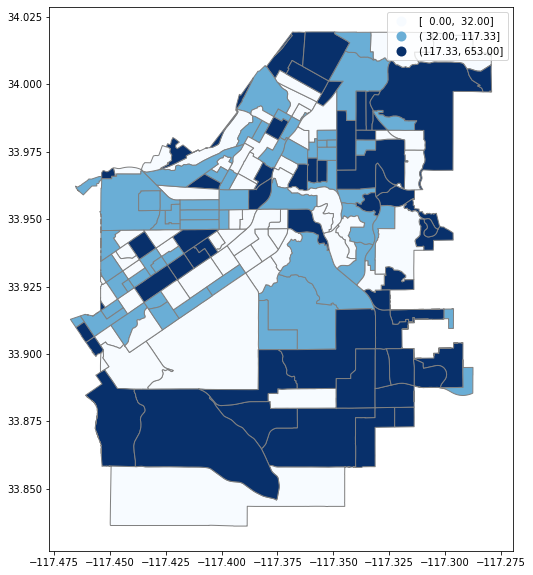

In [91]:
EJ_RUSD_black_dem= rusd_ej[['n_nonhisp_black_persons','geometry']]
EJ_RUSD_black_dem.plot(column='n_nonhisp_black_persons', cmap='Blues', scheme='Quantiles', k=3,edgecolor='grey',
        legend=True)

EJ & RUSD and Hispanic Demographics 

<AxesSubplot:>

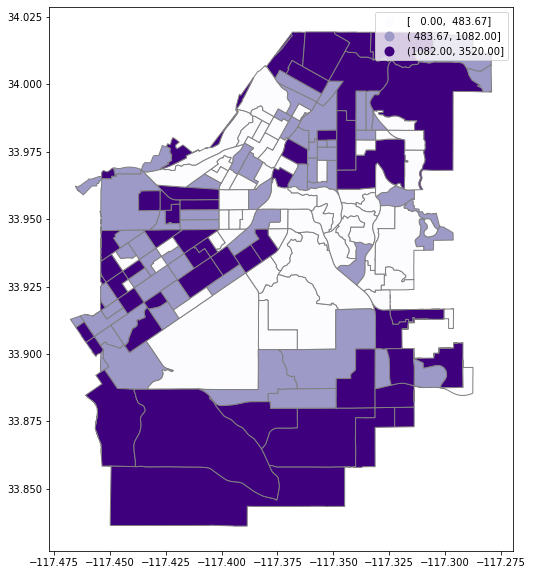

In [93]:
EJ_RUSD_hispanic_dem= rusd_ej[['n_hispanic_persons','geometry']]
EJ_RUSD_hispanic_dem.plot(column='n_hispanic_persons', cmap='Purples', scheme='Quantiles', k=3,edgecolor='grey',
        legend=True)

### 5.1 Overlays

#### Approach 1 Spatial Join

<AxesSubplot:>

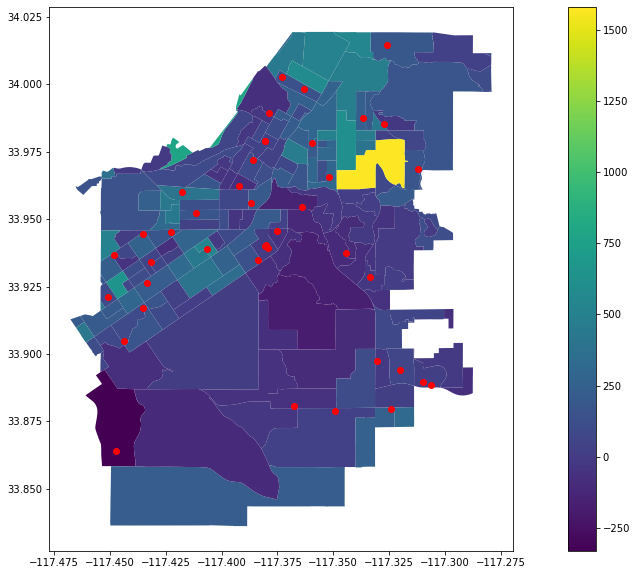

In [30]:
# 1 for 1 mapping
base  = EJ_RUSD.plot(column='D_RESP_2', legend=True)
rusd_pts.plot(color='red', ax=base)

In [31]:
rusd_sch= gpd.sjoin(rusd_pts, EJ_RUSD, how='left', op='within')
rusd_sch.head()

,gcs_mn_avg_ol,geometry,index_right,D_RESP_2
0,8.098470,POINT (-117.30967 33.88970),135,23.698113
1,4.939048,POINT (-117.30644 33.88844),135,23.698113
2,3.253884,POINT (-117.43514 33.94446),85,261.324237
3,3.960433,POINT (-117.36408 33.95469),36,-142.849901
4,3.599937,POINT (-117.37885 33.98955),6,-62.781118


In [33]:
schools['escore1'] = schools_escore1.escore

NameError: name 'schools_escore1' is not defined

In [41]:
rusd_pts['D_RESP_2a'] = rusd_sch.D_RESP_2
rusd_pts.head()

/opt/tljh/user/lib/python3.7/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


,gcs_mn_avg_ol,geometry,D_RESP_2a
0,8.098470,POINT (-117.30967 33.88970),23.698113
1,4.939048,POINT (-117.30644 33.88844),23.698113
2,3.253884,POINT (-117.43514 33.94446),261.324237
3,3.960433,POINT (-117.36408 33.95469),-142.849901
4,3.599937,POINT (-117.37885 33.98955),-62.781118


In [ ]:
rusd_pts.crs

#### Approach 2 Areal Interpolation

In [ ]:
x = rusd_pts.geometry.x
y = rusd_pts.geometry.y
cents = np.array([x,y]).T
cents

In [ ]:
schools_vd, school_cents = lps.cg.voronoi_frames(cents)
# Schools_vd has polygons geometry
# school_cents has points geometry

In [ ]:
school_cents.head()


In [ ]:
base = schools_vd.plot()
rusd_pts.plot(ax=base, color='red')

In [ ]:
EJ_RUSD.crs

In [ ]:
base = EJ_RUSD.geometry.boundary.plot(edgecolor='green')
schools_vd.plot(ax=base)
rusd_pts.plot(ax=base, color='red')

In [ ]:
schools_vd, school_cents = lps.cg.voronoi_frames(cents, clip = EJ_RUSD.unary_union)

In [ ]:
base = EJ_RUSD.geometry.boundary.plot(edgecolor='green')
schools_vd.plot(ax=base)
rusd_pts.plot(ax=base, color='red')

In [ ]:
base = EJ_RUSD.plot(column='D_RESP_2')
schools_vd.geometry.boundary.plot(ax=base, edgecolor='white')
rusd_pts.plot(ax=base, color='red')

Estimate the EJ_respiratory hazards for a school using areal interpolation

In [ ]:
type(schools_vd)

In [ ]:
# setting schools_vd to have crs
schools_vd.crs = "EPSG:4269"

In [ ]:
x = schools_vd.to_crs(epsg=4269)

In [ ]:
RESP = tob.area_weighted.area_interpolate(source_df=EJ_RUSD,
                                           target_df=x,
                                           intensive_variables=['D_RESP_2'])

In [ ]:
RESP.head()

In [ ]:
base = RESP.plot(column='D_RESP_2')
rusd_pts.plot(ax=base, color='red')

In [ ]:
rusd_pts['D_RESP_2b'] = RESP.D_RESP_2
rusd_pts.head()

In [ ]:
import seaborn as sns
f, ax = plt.subplots(figsize=(6, 6))
x='D_RESP_2a'
y='D_RESP_2b'
sns.scatterplot(x=x, y=y, s=5, color=".15", data=rusd_pts)
sns.histplot(x=x, y=y, bins=50, pthresh=.1, cmap="mako", data=rusd_pts)
sns.kdeplot(x=x, y=y, levels=5, color="b", linewidths=1, data=rusd_pts)

In [ ]:
#sns.scatterplot(data=rusd_pts, x="D_RESP_2a", y="D_RESP_2b")

In [ ]:
# mapping one for one relationship
sns.scatterplot(data=rusd_pts, x="D_RESP_2a", y="gcs_mn_avg_ol")

In [ ]:
x='D_RESP_2a'
y='gcs_mn_avg_ol'
sns.scatterplot(x=x, y=y, s=5, color=".15", data=rusd_pts)
sns.histplot(x=x, y=y, bins=50, pthresh=.1, cmap="mako", data=rusd_pts)
sns.kdeplot(x=x, y=y, levels=5, color="b", linewidths=1, data=rusd_pts)

In [ ]:
# mapping areal interpolation EJ respiratory Index
sns.scatterplot(data=rusd_pts, x="D_RESP_2a", y="gcs_mn_avg_ol")

In [ ]:
EJ_new= rusd_pts[['D_RESP_2a','D_RESP_2b']]

In [ ]:
sns.boxplot(data=EJ_new)

## TASK 

- Include SES and racial composition and restimate the analysis for voronio
- Make a line through the scatter plot 